<a href="https://colab.research.google.com/github/Eunchae-L/LLM-Chatbot/blob/main/Tool_%EA%B8%B0%EC%B4%88.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**[저번 세션 복습]**


## **개념 복습**

https://www.tldraw.com/v/lBkHOaXTj-O-qNN2g_D1S?v=-6274,-3845,16469,8226&p=v9dym-w-y_Fq-T0DbFUXV

In [ ]:
%%writefile app.py

import streamlit as st
from openai import OpenAI

#APIkey 넣어주세요
API_KEY = "____________"


st.title("☁️🐯KAIROS")


# Set OpenAI API key from Streamlit secrets
client = OpenAI(api_key=API_KEY)

# Set a default model
if "openai_model" not in st.session_state:
    st.session_state.openai_model = "gpt-3.5-turbo"

# Initialize chat history
if "messages" not in st.session_state:
    st.session_state.messages = []


# Display chat messages from history on app rerun
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

# Accept user input for chat
if prompt := st.chat_input("무엇이든 물어보세요"):
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})

    # Display user message in chat message container
    with st.chat_message("user"):
        st.markdown(prompt)

    # Display assistant response in chat message container
    with st.chat_message("assistant"):
        message_placeholder = st.empty()
        full_response = ""

        for response in client.chat.completions.create(
            model=st.session_state["openai_model"],
            messages=[{"role": "user", "content": prompt}],
            stream=True,
        ):
            full_response += (response.choices[0].delta.content or "")
            message_placeholder.markdown(full_response + "▌")
        message_placeholder.markdown(full_response)
    st.session_state.messages.append({"role": "assistant", "content": full_response})

Writing app.py


# **Function call, Tool 개념**

**이거 뭐야 왜 사용하는거야??**
- LLM은 학습된 데이터를 기반으로 다음에 나올 단어를 뱉어낼 뿐.
- 예를 들어, 유저가 오늘의 날씨를 물어보면 오늘의 날씨를 알 수가 없기 때문에 말을 지어내게 된다.
- 만약에 LLM이 유저 DB에 필요한 정보가 있다면? 노션에 글을 쓰도록 하고 싶다면?
- LLM이 단어를 생성하는 것을 넘어 실제 세상과 인터랙션을 가능하도록 하는 것이 Tool이다.
- Chat Completions API를 외부 기능과 함께 사용하여 GPT 모델의 기능을 확장할 수 있다!!

예를 들어,
- 수학, 과학 등의 연산/추론 능력을 향상시킬 수 있다. (수학, 과학 관련 라이브러리)
- 실시간 데이터(날씨, 기사, 검색 등)에 접근 가능
- DB, 구글 드라이브, 노션 등 다양한 서비스에 접근할 수 있음
  - 내 노션 페이지에 요약한 데이터를 저장하거나
  - 블로그에 자동으로 글을 업로드하거나
  - 지도 DB에서 실제 맛집 데이터를 가져오거나
  - 구글 드라이브에 있는 파일에 접근할 수 있다.

## **Function Call 이란?**

- GPT가 사용할 수 있는 함수/툴에 대해 설명하는 **시스템 프롬프트**를 의미한다.

먼저, 문제를 해결하기 위해 정의된 함수가 있어야한다.
- 그 다음, 크게 2가지를 제공해야 하는데,
  1. 함수가 언제 사용되는지,
  2. 함수를 실행하기 위해서 어떤 인자가 필요한지
   
  
- **JSON Schema** 형식으로 제공한다.

### 함수의 JSON Schema 작성 형식


```
function: [
  {
    "함수이름",
    "함수에 대한 설명"(어떤 상황에 쓰일지 설명하는 매우 중요한 프롬프트),
    "parameter": {
      {parameter1에 대한 설명},
      {parameter2에 대한 설명},
      ...
      {요구되는 parameter}
    }
  },
  {*...*}
]
```



## **Function Call의 동작 순서**

1. 유저의 쿼리(Query)/메시지가 입력된다.
2. GPT는 유저 메시지에 따라 특정 함수를 사용해야 한다고 판단하면, 실행할 함수의 이름과 함수를 실행할 때 필요한 인풋(Argument)를 함께 제공한다.
  - 예를 들어, 사칙연산을 하는 챗봇을 만든다고 하면, 해당 챗봇에게는 수학 계산을 하는 함수가 제공될 것이다. 유저가 "좋아, 이제 358 * 49를 계산해줘"라고 한다면, 함수이름: "multiply", 인자: "a=358, b=49"를 답변할 것이다.
  - 때로는 특정 함수만을 사용하도록 강제할 수 있다. `function_choice` ,`tool_choice`등의 parameter이용
3. LLM이 제공받은 함수이름과 인자를 통해 함수를 실행한다.
  - (OpenAI 왈)LLM은 실제로 함수를 실행하지 않습니다. GPT의  함수를 실행하는 것은 개발자의 몫이다.  
4. 그렇게 실행된 함수의 결과를 LLM에게 다시 알려주고 답변을 뽑아내야 한다. (role=function)


\
```
핵심: LLM이 툴을 사용할 때는 꼭 2번의 호출이 일어나야 한다!!!
```




![image](https://drive.google.com/uc?export=view&id=1Lpxb3k8-YJf-kMhrRY7nKhl7GlUHVyPJ)

![image](https://drive.google.com/uc?export=view&id=15qYsoEvZG0vBS5qv4_xC9Oxhl9cLYy1x)

![image](https://drive.google.com/uc?export=view&id=1ukZbMC2GxUIIE74op8S7_fZFUIopO30-)

![image](https://drive.google.com/uc?export=view&id=1zaA6jVGPHsSlBbg3yaLb6c_rOsWNuFBk)

![image](https://drive.google.com/uc?export=view&id=1DXtSgQPWq7hdg4-0pjtBJpg5HLoljHgB)

>> 즉 gpt는 함수가 어떤식으로 실행되는지가 중요한게 아니라 함수가 어떤 결과를 가져오는지만 알면 된다.

# 현재 날씨 알려주는 챗봇 만들기
https://openweathermap.org/api

In [ ]:
# weathermap_api_key
weather_api_key= "_________________"

## function calling 원리

### 먼저 개발자가 필요한 함수를 정의해야한다.
우리는 날씨 데이터를 받아오는 챗봇을 만들기 위함이니 OpenWeatherMap_api를 이용하여 날씨 정보를 가져오는 함수를 정의한다.
---



In [ ]:
import requests

def get_current_weather(location, format):
    # OpenWeatherMap API 키를 'your_api_key_here' 자리에 실제 키로 교체하세요
    api_key = 'your_api_key_here'
    # 현재 날씨 정보를 위한 OpenWeatherMap API 엔드포인트
    base_url = "http://api.openweathermap.org/data/2.5/weather?"

    # API 요청을 위한 온도 단위 시스템을 포맷에 따라 변환
    units = 'metric' if format == 'celsius' else 'imperial'

    # 파라미터를 포함하여 완성된 API URL 구성
    complete_url = f"{base_url}appid={api_key}&q={location}&units={units}"

    # API 요청 수행
    response = requests.get(complete_url)
    print(response)
    # 요청이 성공적이었는지 확인
    if response.status_code == 200:
        # 응답 JSON 파싱
        data = response.json()

        # 관련 날씨 정보 추출
        temperature = data['main']['temp']
        weather_description = data['weather'][0]['description']

        # 결과 문자열 구성
        result = (f"'location':{location}, 'temperature':{temperature},'format':{format}, 'weather_description':{weather_description}")
        return result
    else:
        # 가능한 오류 처리(예: 위치를 찾을 수 없음)
        return "날씨 정보를 가져올 수 없습니다. 위치를 확인하고 다시 시도하세요."


In [ ]:
print(get_current_weather(location ="seoul",format="celsius"))

<Response [200]>
{'coord': {'lon': 126.9778, 'lat': 37.5683}, 'weather': [{'id': 800, 'main': 'Clear', 'description': 'clear sky', 'icon': '01n'}], 'base': 'stations', 'main': {'temp': 3.96, 'feels_like': 0.23, 'temp_min': 3.69, 'temp_max': 4.66, 'pressure': 1018, 'humidity': 60}, 'visibility': 10000, 'wind': {'speed': 4.63, 'deg': 300}, 'clouds': {'all': 0}, 'dt': 1710861726, 'sys': {'type': 1, 'id': 8105, 'country': 'KR', 'sunrise': 1710884145, 'sunset': 1710927801}, 'timezone': 32400, 'id': 1835848, 'name': 'Seoul', 'cod': 200}
'location:seoul, 'temperature':3.96,'format':celsius, 'weather_description':clear sky


In [ ]:
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "현재 위치의 현재 날씨를 확인합니다.",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "도시(예: 서울)",
                    },
                    "format": {
                        "type": "string",
                        "enum": ["celsius", "fahrenheit"],
                        "description": "사용할 온도 단위입니다. 사용자 위치에서 이를 유추합니다.",
                    },
                },
                "required": ["location", "format"],
            },
        }
    }]

---

##Function call을 이용해 gpt에게 답변 받기



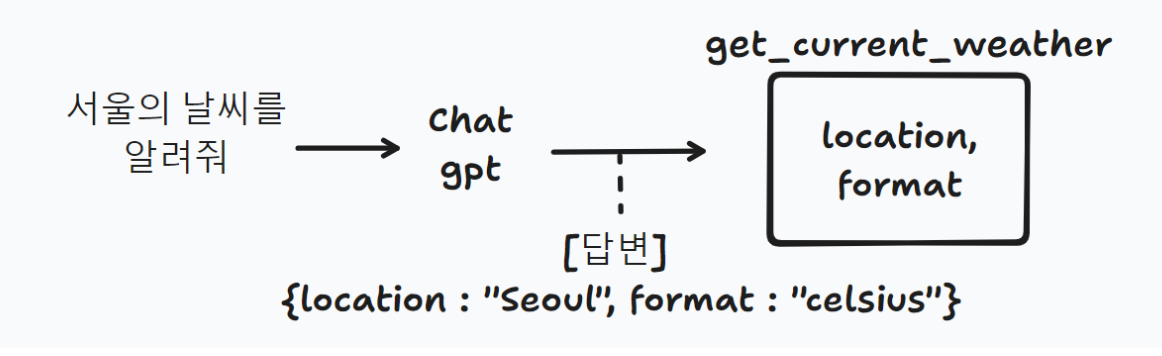

* 유저의 쿼리가 gpt에게 전달된다.
* gpt가 바로 답변하는 것보다 함수의 실행이 필요하다고 판단하면, 유저의 쿼리에서 함수에 넣을 수 있는 적절한 형태를 만든다.
* 적절한 형태로 바꾼 후, 함수에 넣어서 원하는 정보를 얻을 수 있도록 한다.
* 이 정보를 다시 gpt를 통해 알아 듣기 쉬운 언어로 다시 출력한다.


###1. API key

In [ ]:
!pip install streamlit
!pip install openai
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 262.4/262.4 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.6/75.6 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 5.7 MB/s eta 0:00:00


In [ ]:
from openai import OpenAI

# Open AI API key 입력해주세요
client = OpenAI(api_key="")

###**2. gpt의 답변 받기**

**자연어를 함수에 넣을 수 있는 형태로 만들기!**

* messages : gpt에게 보낼 메세지

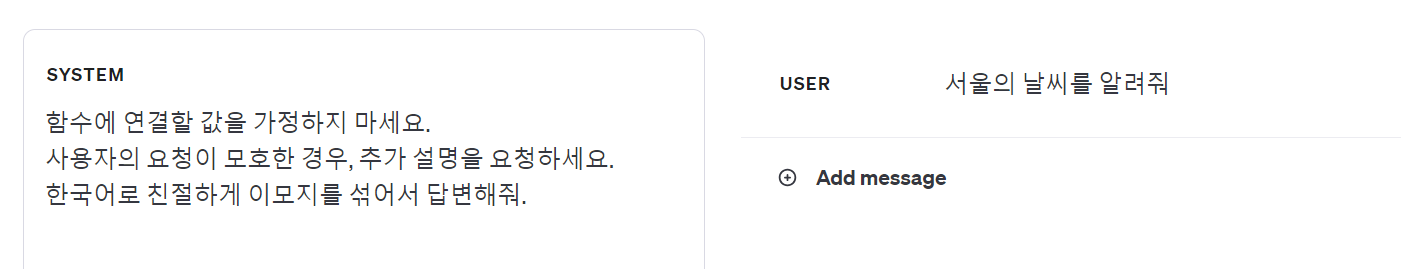

In [ ]:
messages = []

messages.append({
    "role": "system",
    "content": "함수에 연결할 값을 가정하지 마세요.\
      사용자의 요청이 모호한 경우 추가 설명을 요청하세요\
      한국어로 친절하게 이모지를 섞어서 답변해줘"
    })

prompt = "서울의 날씨를 알려줘"

messages.append({"role": "user", "content": prompt})


* response : gpt의 답변

-> 이 답변을 통해 {location : "seoul", format:"celsius"} 이런 형식으로 받아와야 함.

In [ ]:
response = client.chat.completions.create(
            model="gpt-3.5-turbo",
            messages=messages,
            tools=tools
            )
response

#<답변>
# ChatCompletion(
#     id='chatcmpl-94WFJURFEWmDkIDdjhZ0znxU6Zd8E',
#     choices=[
#         Choice(
#             finish_reason='tool_calls',
#             index=0,
#             logprobs=None,
#             message=ChatCompletionMessage(
#                 content=None,
#                 role='assistant',
#                 function_call=None,
#                 tool_calls=[
#                     ChatCompletionMessageToolCall(
#                         id='call_mvdjbS5aumHodLuTClsXkzb0',
#                         function=Function(
#                             arguments='{"location":"Seoul","format":"celsius"}',
#                             name='get_current_weather'
#                         ),
#                         type='function'
#                     )
#                 ]
#             )
#        )
#     ],
#     created=1710864293,
#     model='gpt-3.5-turbo-0125',
#     object='chat.completion',
#     system_fingerprint='fp_4f2ebda25a',
#     usage=CompletionUsage(completion_tokens =21, prompt_tokens=158, total_tokens=179)
# ) description

ChatCompletion(id='chatcmpl-95AiHlbo1IgqS0jbIkloWKWfOvijL', choices=[Choice(finish_reason='tool_calls', index=0, logprobs=None, message=ChatCompletionMessage(content=None, role='assistant', function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_1cCMtYUQqZz7eC4J09Q0PcEP', function=Function(arguments='{"location":"서울","format":"celsius"}', name='get_current_weather'), type='function')]))], created=1711019849, model='gpt-3.5-turbo-0125', object='chat.completion', system_fingerprint='fp_fa89f7a861', usage=CompletionUsage(completion_tokens=22, prompt_tokens=179, total_tokens=201))

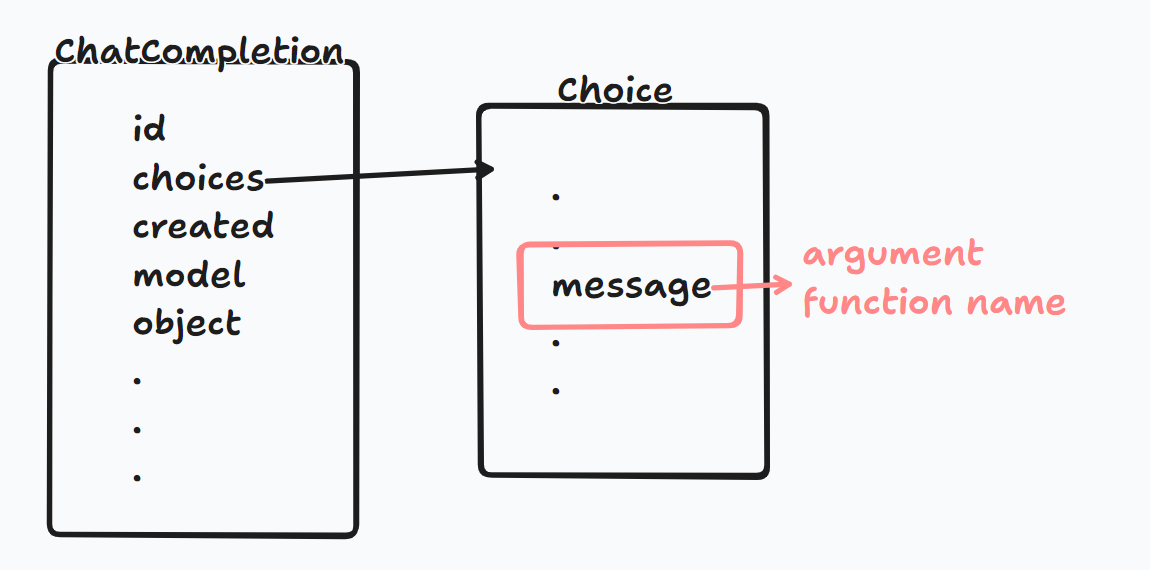

**<functon_name을 받아오는 이유>**

이번 실습에서는 function을 하나만 사용하지만 실제로는 여러 개를 사용하고 gpt가 사용하는 function이 답변마다 다를 수 있음.

그렇기 때문에 function_name을 받아와서 어떤 함수를 사용하였는지 알아야 한다!


\
**<json.loads()함수>**

**response_message.tool_calls[0].function.arguments** 이 형태는 json형태로 되어있기 때문에

이 함수를 통해 파이썬의 dictionary 형태로 바꾼다.

In [ ]:
import json

response_message = response.choices[0].message
function_name = response_message.tool_calls[0].function.name
arguments = json.loads(response_message.tool_calls[0].function.arguments)
arguments

{'location': '서울', 'format': 'celsius'}

function_name과 argument를 통해 함수를 실행해야 됨.

> 즉, get_current_weather(location="seoul",format="celsius") 실행

**< eval()함수 >**

문자열을 실행시킬 수 있는 함수

\
**< arguments >**

딕셔너리 형태를 함수에 넣을 수 있는 키워드 인자로 바꿔줌


In [ ]:
# 함수에 인자값을 넣어 실행하기
# 아래의 명령어는 function_response = get_current_weather(location="seoul",format="celsius")과 같다.
function_response = eval(f"{function_name}(**arguments)")

function_response
# {
#     'coord': {
#         'lon': 126.9778,
#         'lat': 37.5683
#     },
#     'weather': [
#         {
#             'id': 802,
#             'main': 'Clouds',
#             'description': 'scattered clouds',
#             'icon': '03n'
#         }
#     ],
#     'base': 'stations',
#     'main': {
#         'temp': 3.96,
#         'feels_like': -0.5,
#         'temp_min': 3.76,
#         'temp_max': 4.69,
#         'pressure': 1018,
#         'humidity': 60
#     },
#     'visibility': 10000,
#     'wind': {
#         'speed': 6.17,
#         'deg': 300
#     },
#     'clouds': {'all': 40},
#     'dt': 1710858893,
#     'sys': {
#         'type': 1,
#         'id': 8105,
#         'country': 'KR',
#         'sunrise': 1710797837,
#         'sunset': 1710841347
#     },
#     'timezone': 32400,
#     'id': 1835848,
#     'name': 'Seoul',
#     'cod': 200
# }

{'coord': {'lon': 126.9778, 'lat': 37.5683}, 'weather': [{'id': 802, 'main': 'Clouds', 'description': 'scattered clouds', 'icon': '03n'}], 'base': 'stations', 'main': {'temp': 3.96, 'feels_like': -0.5, 'temp_min': 3.76, 'temp_max': 4.69, 'pressure': 1018, 'humidity': 60}, 'visibility': 10000, 'wind': {'speed': 6.17, 'deg': 300}, 'clouds': {'all': 40}, 'dt': 1710858893, 'sys': {'type': 1, 'id': 8105, 'country': 'KR', 'sunrise': 1710797837, 'sunset': 1710841347}, 'timezone': 32400, 'id': 1835848, 'name': 'Seoul', 'cod': 200}
'location:Seoul, 'temperature':3.96,'format':celsius, 'weather_description':scattered clouds


**함수에서 받아온 정보를 gpt에게 다시 넣어서 답변 받아오기**

In [ ]:
response = client.chat.completions.create(
    model="gpt-3.5-turbo",
    messages=[
	    {"role": "user", "content": prompt},
	    {"role": "function", "name": function_name, "content": function_response}
	 ],
    tools=tools
)


In [ ]:
print(response.choices[0].message.content)

서울의 현재 날씨는 구름이 조금 있는 상태이고, 온도는 약 3.96°C 입니다.


###Streamlit 적용

In [ ]:
#라이브러리 설치
!pip install streamlit
!pip install pyngrok
!pip install openai

In [ ]:
!ngrok authtoken

In [ ]:
%%writefile app.py

import streamlit as st
from openai import OpenAI
import json
import requests

API_KEY = ""
weather_api_key= ""

st.title("날씨봇🌤️")

# Set OpenAI API key from Streamlit secrets
client = OpenAI(api_key=API_KEY)

# Set a default model
if "openai_model" not in st.session_state:
    st.session_state.openai_model = "gpt-3.5-turbo"

# Initialize chat history
if "messages" not in st.session_state:
    st.session_state.messages = [{
      "role": "system",
      "content": "함수에 연결할 값을 가정하지 마세요.\
      사용자의 요청이 모호한 경우 설명을 요청하세요\
      한국어로 친절하게 이모지를 섞어서 답변해줘"
      }]


def get_current_weather(location, format):
    # Replace 'your_api_key_here' with your actual OpenWeatherMap API key
    api_key = weather_api_key
    # OpenWeatherMap API endpoint for current weather
    base_url = "http://api.openweathermap.org/data/2.5/weather?"

    # Convert the format to the corresponding unit system for the API request
    units = 'metric' if format == 'celsius' else 'imperial'

    # Construct the complete API URL with parameters
    complete_url = f"{base_url}appid={api_key}&q={location}&units={units}"

    # Perform the API request
    response = requests.get(complete_url)

    # Check if the request was successful
    if response.status_code == 200:
        # Parse the response JSON
        data = response.json()

        # Extract relevant weather information
        temperature = data['main']['temp']
        weather_description = data['weather'][0]['description']

        # Construct a result string
        result = (f"'location:{location}, 'temperature':{temperature},'format':{format}, 'weather_description':{weather_description}")
        return result
    else:
        # Handle possible errors (e.g., location not found)
        return "Weather information could not be retrieved. Please check the location and try again."

tools = [
    {
        "type": "function",
        "function": {
            "name": "get_current_weather",
            "description": "Get the current weather",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city and state, e.g. Seoul",
                    },
                    "format": {
                        "type": "string",
                        "enum": ["celsius", "fahrenheit"],
                        "description": "The temperature unit to use. Infer this from the users location.",
                    },
                },
                "required": ["location", "format"],
            },
        }
    }]


# Display chat messages from history on app rerun
for message in st.session_state.messages:
    with st.chat_message(message["role"]):
        st.markdown(message["content"])

# Accept user input for chat
if prompt := st.chat_input("날씨에 대해 물어보세요"):
    # Add user message to chat history
    st.session_state.messages.append({"role": "user", "content": prompt})

    # Display user message in chat message container
    with st.chat_message("user"):
        st.markdown(prompt)

    # Display assistant response in chat message container
    with st.chat_message("assistant"):
        message_placeholder = st.empty()
        full_response = ""
        response = client.chat.completions.create(
            model=st.session_state.openai_model,
            messages=st.session_state.messages,
            tools=tools,
            )
        response_message = response.choices[0].message
        function_name = response_message.tool_calls[0].function.name
        arguments = json.loads(response_message.tool_calls[0].function.arguments)
# 함수에 인자값을 넣어 실행하기
        function_response = eval(f"{function_name}(**arguments)")

        st.session_state.messages.append({
          "role":"function",
          "name":function_name,
          "content":function_response
        })

        # 여기부터 시작해야 댈듯
        for response in client.chat.completions.create(
            model=st.session_state.openai_model,
            messages=st.session_state.messages,
            tools = tools,
            stream=True,
        ):
            full_response += (response.choices[0].delta.content or "")
            message_placeholder.markdown(full_response + "▌")
        message_placeholder.markdown(full_response)
    st.session_state.messages.append({"role": "assistant", "content": full_response})



Overwriting app.py


In [ ]:
from pyngrok import ngrok
!streamlit run app.py&>/dev/null&
publ_url = ngrok.connect(addr='8501')
publ_url

<NgrokTunnel: "https://603c-34-138-58-155.ngrok-free.app" -> "http://localhost:8501">

In [ ]:
### streamlit 과 ngrok 종료

In [ ]:
!ps

In [ ]:
!kill <streamlit 번호>

In [ ]:
ngrok.kill()

# 실습 과제

**1. 챗봇 답변에 습도 정보도 표현되도록 만들기**


**2.아래 수학 문제를 맞추는 챗봇 만들기**


![image](https://drive.google.com/uc?export=view&id=1hm7USms2hGgX7lvkzwNwAVdK6N4FOWbh)
